In [5]:
ls

 Volume in drive C has no label.
 Volume Serial Number is EEF8-159E

 Directory of c:\Users\zdimi\Documents\GitHub\TambOpt\notebooks

11/30/2025  07:55 PM    <DIR>          .
11/30/2025  07:50 PM    <DIR>          ..
11/28/2025  12:45 PM            19,123 01_visualize_nn_architecture.ipynb
11/28/2025  12:45 PM             6,521 01_zlt_test_hamza_code.ipynb
11/28/2025  12:45 PM         1,797,520 02_eda_pinn.ipynb
11/28/2025  12:45 PM           566,065 02_eda_raw_data.ipynb
11/28/2025  12:45 PM         1,280,478 03_fnn_small_dataset.ipynb
11/28/2025  12:45 PM         2,884,119 04_fnn_full_dataset.ipynb
11/28/2025  12:45 PM         1,666,320 05_train_using_PINA.ipynb
11/28/2025  12:45 PM         1,719,583 06_train_using_PINA_Cone.ipynb
11/30/2025  08:08 PM         1,719,274 06_train_using_PINA_Cone_50k.ipynb
11/28/2025  12:45 PM         1,372,643 07_tst_PINA_GAROM_sine_wave.ipynb
11/28/2025  12:45 PM         2,137,785 08_train_using_PINA_GAROM.ipynb
11/28/2025  12:45 PM           586,645 

In [7]:
import numpy as np

data = np.load('..\\tambo_pre_processed_files_500000_simulations\\44893085.npz')

In [16]:
data['44893085_117_energy']

array(165194.9, dtype=float32)

In [1]:
# enable autoreloading of modules
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from src.plotting import plot_2d_scatter, plot_histogram, plot_records_per_plane, plot_cone_with_scatter, plot_y_values_per_plane, generate_3d_cone_animation
from src.data_exploration import calculate_max_records_events, select_event_data, print_y_values_per_plane
from src.featurization import calcualte_cone_parameters


## Load data

In [3]:
hit_file = "../ml/processed_events/normalized_features.parquet"
train_data = pd.read_parquet(hit_file)

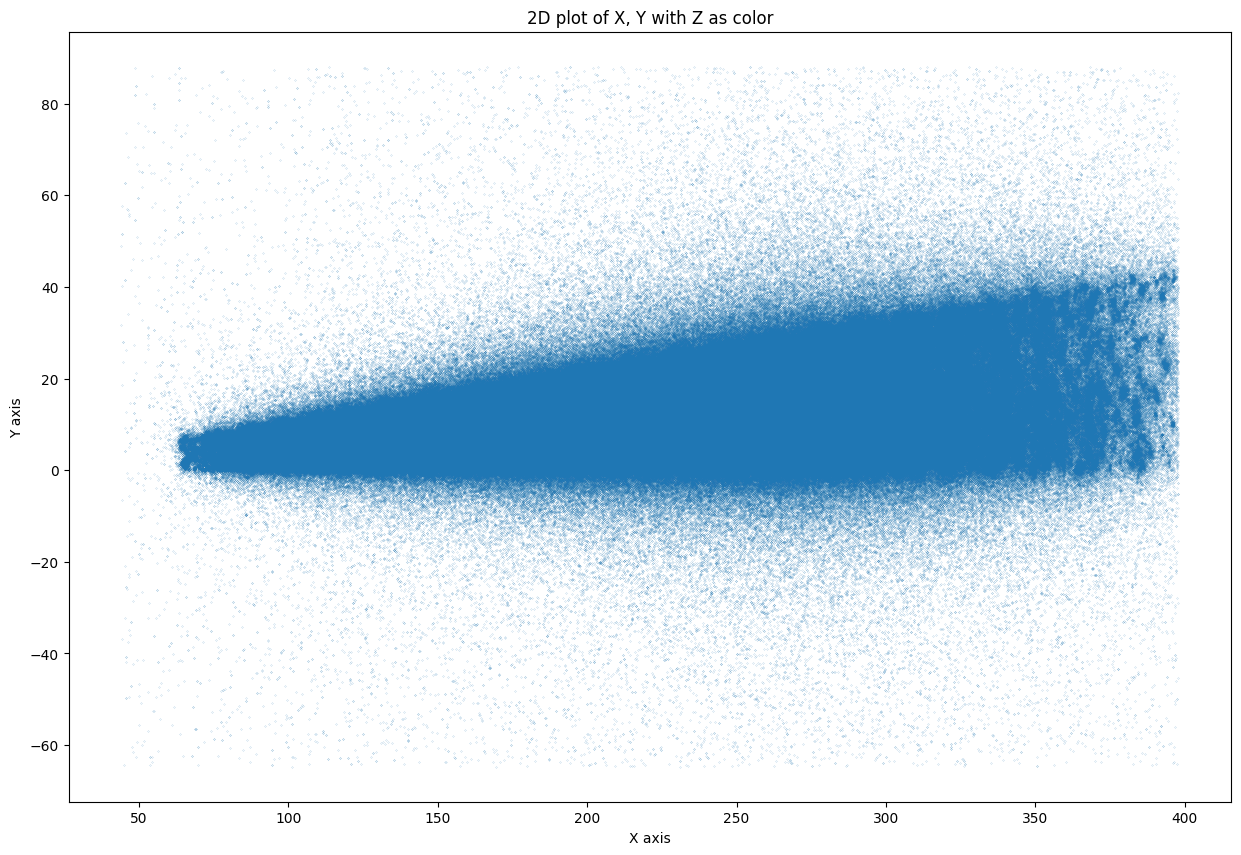

In [4]:
# 2d plot of x,y z, transfomed to 2d, from train_data
figure, ax = plot_2d_scatter(train_data)

## Plot histograms of all columns

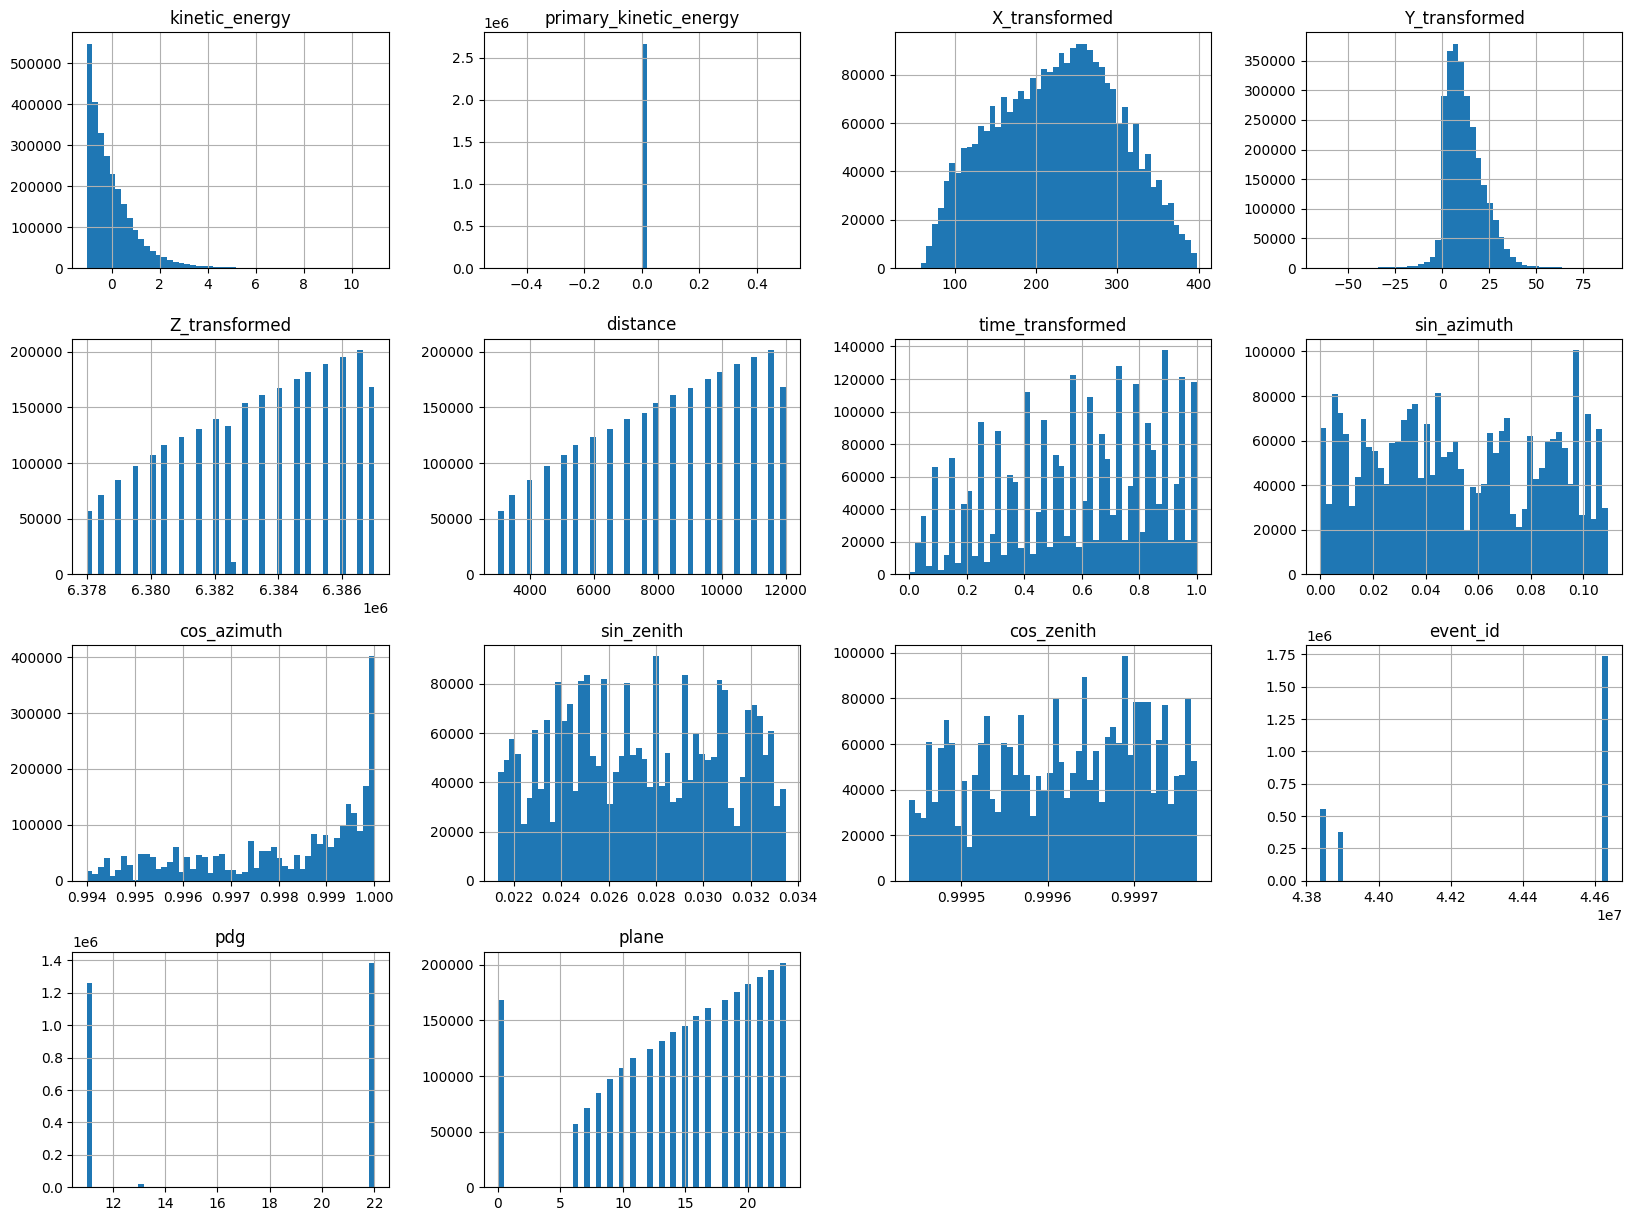

In [5]:
# plot histograms of each feature
axes = train_data.hist(bins=50, figsize=(20,15))

## Plot statistics for events

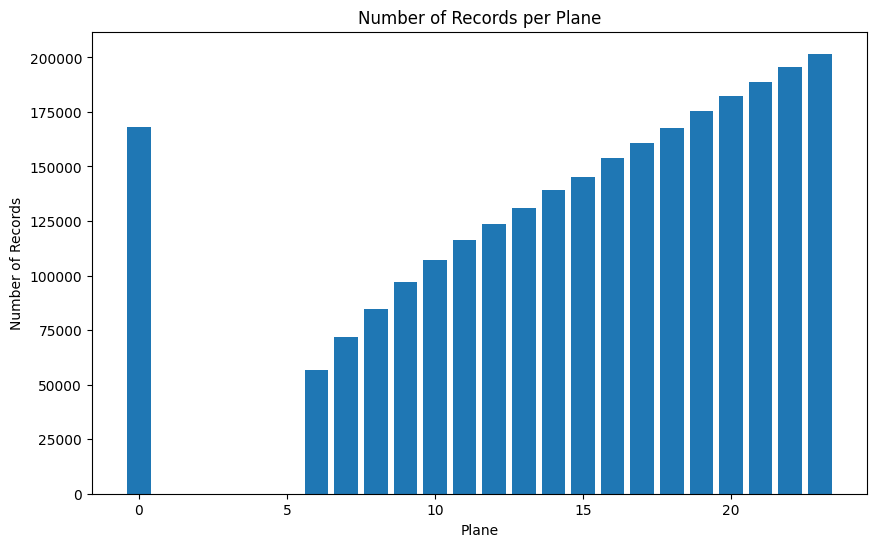

In [6]:
plot_records_per_plane(train_data)

In [7]:
# select top 10 event with most records
max_records_events = calculate_max_records_events(train_data)   
max_records_event = max_records_events[0]

Events with most records: Index([43888008.0, 43888065.0, 44634388.0, 44635212.0, 44634225.0, 43845485.0,
       43888348.0, 43887992.0, 44633576.0, 44633579.0],
      dtype='float64', name='event_id')


In [8]:
top_event_data = select_event_data(train_data, max_records_event)

In [9]:
top_event_data['plane'].unique()

array([22., 23.,  0., 20., 19., 18., 21., 17., 16., 15., 14., 13., 12.,
       10., 11.])

In [10]:
# change plane number 0 to 24 for all reccords in top_event_data after copying
top_event_data = top_event_data.copy()
top_event_data.loc[top_event_data['plane'] == 0, 'plane'] = 24

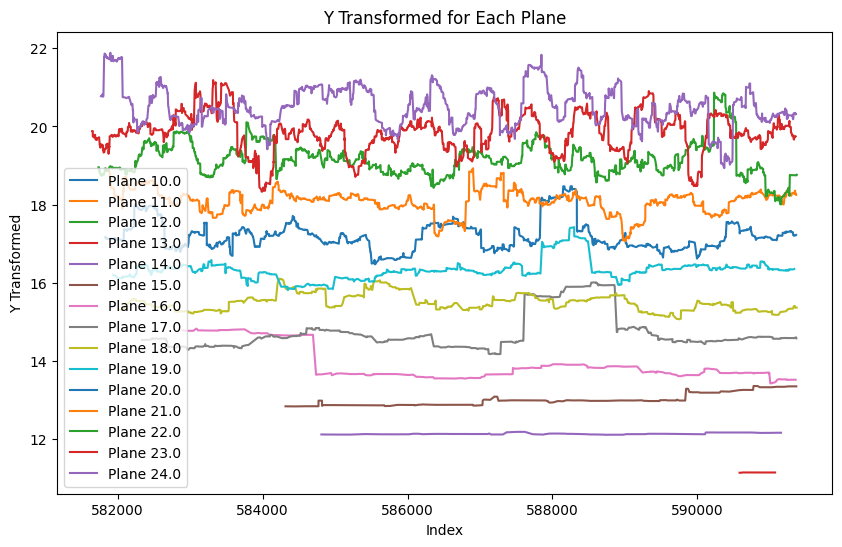

In [11]:
figure = plot_y_values_per_plane(top_event_data)

In [12]:
print_y_values_per_plane(top_event_data)

Plane 10.0: Mean Y Transformed = 8.5862
Plane 11.0: Mean Y Transformed = 9.4449
Plane 12.0: Mean Y Transformed = 10.3038
Plane 13.0: Mean Y Transformed = 11.1471
Plane 14.0: Mean Y Transformed = 12.1255
Plane 15.0: Mean Y Transformed = 13.0650
Plane 16.0: Mean Y Transformed = 13.8479
Plane 17.0: Mean Y Transformed = 14.6852
Plane 18.0: Mean Y Transformed = 15.4916
Plane 19.0: Mean Y Transformed = 16.3128
Plane 20.0: Mean Y Transformed = 17.1982
Plane 21.0: Mean Y Transformed = 18.1111
Plane 22.0: Mean Y Transformed = 19.1420
Plane 23.0: Mean Y Transformed = 19.8215
Plane 24.0: Mean Y Transformed = 20.5120


In [13]:
# generate_3d_cone_animation(top_event_data, output_folder="cone_frames")

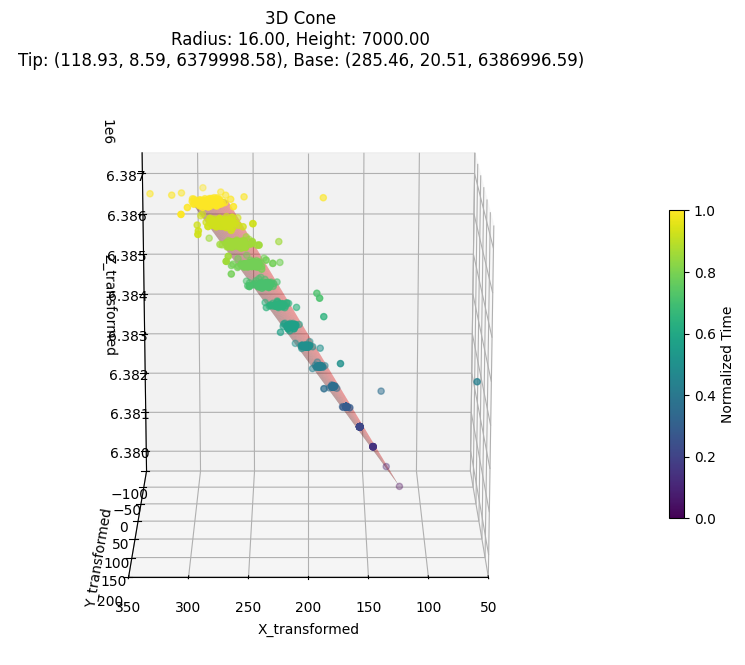

In [14]:
fig, ax = plot_cone_with_scatter(top_event_data, elev=15., azim=90)
plt.show()

# Prepare training data

Select input and output columns

In [15]:
import sklearn as sk
from sklearn.model_selection import train_test_split

input_columns = [
            "primary_kinetic_energy",
            "sin_azimuth", "cos_azimuth", "sin_zenith", "cos_zenith"
        ]
output_columns = [
            "kinetic_energy", 
            "X_transformed", "Y_transformed", "Z_transformed",
        ]
batch_identifier = "event_id"

Calculate meand and std of secondary features

In [16]:
train_data

,kinetic_energy,primary_kinetic_energy,X_transformed,Y_transformed,Z_transformed,distance,time_transformed,sin_azimuth,cos_azimuth,sin_zenith,cos_zenith,event_id,pdg,plane
0,0.914152,-1.065814e-14,349.608654,-1.280883,6.386995e+06,12000.0,0.999994,0.000000,1.000000,0.029175,0.999574,43838896.0,22.0,0.0
1,-0.991635,-1.065814e-14,350.447548,-1.089805,6.386995e+06,12000.0,0.999994,0.000000,1.000000,0.029175,0.999574,43838896.0,22.0,0.0
2,-0.845394,-1.065814e-14,349.970217,-0.764448,6.386995e+06,12000.0,0.999994,0.000000,1.000000,0.029175,0.999574,43838896.0,11.0,0.0
3,-0.854286,-1.065814e-14,348.473013,6.188690,6.386995e+06,12000.0,0.999996,0.000000,1.000000,0.029175,0.999574,43838896.0,22.0,0.0
4,-0.714616,-1.065814e-14,358.300119,5.882210,6.386995e+06,12000.0,0.999996,0.000000,1.000000,0.029175,0.999574,43838896.0,22.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667077,-0.910230,-1.065814e-14,344.079874,3.013528,6.386495e+06,11500.0,0.946687,0.012965,0.999916,0.030087,0.999547,44636002.0,11.0,23.0
2667078,1.198717,-1.065814e-14,345.822849,3.307337,6.386495e+06,11500.0,0.946687,0.012965,0.999916,0.030087,0.999547,44636002.0,22.0,23.0
2667079,-0.698702,-1.065814e-14,345.660347,3.175799,6.386495e+06,11500.0,0.946687,0.012965,0.999916,0.030087,0.999547,44636002.0,11.0,23.0
2667080,1.637200,-1.065814e-14,345.741322,2.966944,6.386495e+06,11500.0,0.946687,0.012965,0.999916,0.030087,0.999547,44636002.0,22.0,23.0


In [17]:
event_stats = train_data

# apply function for each event
event_cone_params = event_stats.groupby(by=[batch_identifier]).apply(calcualte_cone_parameters).reset_index()

# group input features by event_id and drop the rest of the columns
train_data_inputs = train_data.groupby(by=input_columns+[batch_identifier]).first().reset_index()
train_data_inputs = train_data_inputs[input_columns + [batch_identifier]]

# joint to train_data[input_columns] on event_id
train_data_with_cone = train_data_inputs.merge(event_cone_params, on=batch_identifier, how='inner') 

# update output columns
output_columns = [
    'X_mean_min', 'Y_mean_min', 'Z_mean_min',
    'X_mean_max', 'Y_mean_max', 'Z_mean_max',
    'radius'
]

/tmp/ipykernel_1397666/3846671244.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_cone_params = event_stats.groupby(by=[batch_identifier]).apply(calcualte_cone_parameters).reset_index()


In [18]:
train_data_with_cone

,primary_kinetic_energy,sin_azimuth,cos_azimuth,sin_zenith,cos_zenith,event_id,min_plane,max_plane,X_mean_min,Y_mean_min,Z_mean_min,X_mean_max,Y_mean_max,Z_mean_max,radius
0,-1.065814e-14,0.000000,1.000000,0.021705,0.999764,43840362.0,6.0,0.0,65.115798,-0.001796,6.377999e+06,259.507200,1.940294,6.386997e+06,7.921338
1,-1.065814e-14,0.000000,1.000000,0.022240,0.999753,43840971.0,6.0,0.0,66.654101,0.066251,6.377999e+06,266.979022,-0.409004,6.386997e+06,14.597748
2,-1.065814e-14,0.000000,1.000000,0.023551,0.999723,43840950.0,6.0,0.0,70.652034,-0.000785,6.377999e+06,282.892259,-0.172748,6.386997e+06,36.497638
3,-1.065814e-14,0.000000,1.000000,0.023735,0.999718,43840424.0,6.0,0.0,71.914421,-0.213750,6.377999e+06,287.496932,82.875008,6.386997e+06,NaN
4,-1.065814e-14,0.000000,1.000000,0.027665,0.999617,43840801.0,6.0,0.0,83.065690,0.361086,6.377999e+06,330.739254,0.786634,6.386995e+06,48.581440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406,-1.065814e-14,0.109107,0.994030,0.023943,0.999713,44634684.0,6.0,0.0,71.706338,7.752172,6.377999e+06,285.547782,31.457599,6.386997e+06,8.609109
1407,-1.065814e-14,0.109173,0.994023,0.021704,0.999764,43845013.0,6.0,0.0,64.472750,7.367015,6.377999e+06,NaN,NaN,NaN,NaN
1408,-1.065814e-14,0.109268,0.994012,0.027783,0.999614,44634970.0,6.0,0.0,82.170287,9.241851,6.377999e+06,329.933435,32.768426,6.386995e+06,14.398249
1409,-1.065814e-14,0.109311,0.994008,0.030200,0.999544,44635398.0,6.0,0.0,90.175242,10.177428,6.377999e+06,353.445161,37.804194,6.386995e+06,61.169629


In [19]:
train_data_with_cone.shape

(1411, 15)

Impute nan values

In [20]:
# validate na values before imputation
print(f"NA values before imputation:\n{train_data_with_cone.isnull().sum()}")

# impute na with 0
train_data_with_cone = train_data_with_cone.dropna()

# validate na values after imputation
print(f"NA values after imputation:\n{train_data_with_cone.isnull().sum()}")

NA values before imputation:
primary_kinetic_energy      0
sin_azimuth                 0
cos_azimuth                 0
sin_zenith                  0
cos_zenith                  0
event_id                    0
min_plane                   6
max_plane                   0
X_mean_min                  6
Y_mean_min                  6
Z_mean_min                  6
X_mean_max                253
Y_mean_max                253
Z_mean_max                253
radius                    342
dtype: int64
NA values after imputation:
primary_kinetic_energy    0
sin_azimuth               0
cos_azimuth               0
sin_zenith                0
cos_zenith                0
event_id                  0
min_plane                 0
max_plane                 0
X_mean_min                0
Y_mean_min                0
Z_mean_min                0
X_mean_max                0
Y_mean_max                0
Z_mean_max                0
radius                    0
dtype: int64


In [21]:
print(f"Event stats columns: {event_stats.columns}")
print(f"Input columns: {input_columns}")
print(f"Output columns: {output_columns}")

Event stats columns: Index(['kinetic_energy', 'primary_kinetic_energy', 'X_transformed',
       'Y_transformed', 'Z_transformed', 'distance', 'time_transformed',
       'sin_azimuth', 'cos_azimuth', 'sin_zenith', 'cos_zenith', 'event_id',
       'pdg', 'plane'],
      dtype='object')
Input columns: ['primary_kinetic_energy', 'sin_azimuth', 'cos_azimuth', 'sin_zenith', 'cos_zenith']
Output columns: ['X_mean_min', 'Y_mean_min', 'Z_mean_min', 'X_mean_max', 'Y_mean_max', 'Z_mean_max', 'radius']


# Define NN using PINA

Test train split

In [22]:
from sklearn.preprocessing import StandardScaler

# split inputs and outputs 
X = train_data_with_cone[input_columns]
y = train_data_with_cone[output_columns]


# y_normalized = y - y.mean()
# y_max = y_normalized.max().max()
# y_normalized = y_normalized / y_max

# create scaler for each output column
y_scaler = StandardScaler()

# fit and transform each column separately
y_normalized = y_scaler.fit_transform(y)

PINA

In [23]:
# import seaborn as sns

# temp_input = pd.concat([y_normalized, X])
# # columns to exclude from the pairplot
# exclude_cols = ['event_id', 'primary_kinetic_energy', 'min_plane', 'max_plane']

# # build dataframe for plotting (only numeric columns)
# plot_df = temp_input.drop(columns=[c for c in exclude_cols if c in temp_input.columns])
# plot_df = plot_df.select_dtypes(include='number')

# sns.pairplot(plot_df)

In [24]:
from pina import Trainer, Condition, LabelTensor
from pina.problem import AbstractProblem
from src.nn import Model
from pina.optim import TorchOptimizer, TorchScheduler
from pina.solver import DeepEnsembleSupervisedSolver
from pina.callback import MetricTracker
import torch



In [26]:
x_pina = LabelTensor(X.values, input_columns)
y_pina = LabelTensor(y_normalized, output_columns)

In [27]:
class BayesianProblem(AbstractProblem):

    output_variables = output_columns
    input_variables = input_columns
    conditions = {"data": Condition(input=x_pina, target=y_pina)}


problem = BayesianProblem()

In [28]:
n_models = 2

# define problem & data (step 1)


models = [
  Model(
      input_dimensions=len(problem.input_variables),
      output_dimensions=len(problem.output_variables),
      layers=[100, 100, 100],
      func=torch.nn.Tanh
  )
  for _ in range(n_models)
]

optimizers = [
     TorchOptimizer(torch.optim.RAdam, lr=0.005)
     for _ in range(n_models)
]

schedulers = [
    TorchScheduler(torch.optim.lr_scheduler.MultiStepLR, milestones=[50, 100, 300, 500, 800], gamma=0.5)
    for _ in range(n_models)
]

In [29]:
solver = DeepEnsembleSupervisedSolver(
    problem,
    models,
    optimizers=optimizers,
    schedulers=schedulers
    )

In [30]:
# create the trainer
trainer = Trainer(
    solver=solver,  # The ensemble solver
    max_epochs=1000,  # Maximum number of training epochs
    logger=True,  # Enables logging (default logger is CSVLogger)
    callbacks=[MetricTracker()],  # Tracks training metrics using MetricTracker
    accelerator="cpu",  # Use CPU for training, alternative is "gpu" for GPU training
    train_size=0.7,  # Fraction of the dataset used for training (70%)
    test_size=0.2,  # Fraction of the dataset used for testing (20%)
    val_size=0.1,  # Fraction of the dataset used for validation (10%)
)

import time

start = time.time()
# train
trainer.train()
end = time.time()
print(f"Training time: {end - start} seconds")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
2025-11-23 11:26:52.474268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 11:26:52.811196: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name         | Type       | Params | Mode 
---------------------------------------

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 23.51it/s, v_num=24, val_loss=0.573, data_loss=0.501, train_loss=0.501] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 19.30it/s, v_num=24, val_loss=0.573, data_loss=0.501, train_loss=0.501]
Training time: 62.56596326828003 seconds


Plot loss

In [31]:
# inspecting final loss
trainer.logged_metrics

{'val_loss': tensor(0.5734),
 'data_loss': tensor(0.5007),
 'train_loss': tensor(0.5007)}

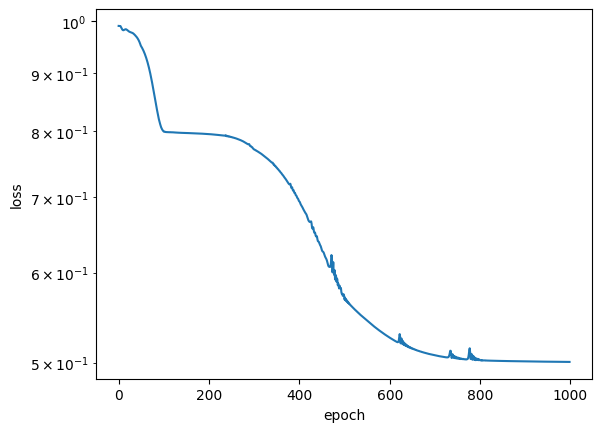

In [32]:
# plot loss
trainer_metrics = trainer.callbacks[0].metrics
loss = trainer_metrics["train_loss"]
epochs = range(len(loss))
plt.plot(epochs, loss.cpu())
# plotting
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")

# Test NN: Plot errors in output/target features

In [33]:
all_outputs = None
all_targets = None

trainer.data_module.setup("test")
with torch.no_grad():
    for data in trainer.data_module.test_dataloader():
    # for data in trainer.data_module.train_dataloader():
        inputs, target = data[0][1]["input"], data[0][1]["target"]
        outputs = solver(inputs)
        
        if all_outputs is None:
            all_outputs = LabelTensor(outputs, labels=output_columns)
            all_targets = target
        else:
            all_outputs.append(LabelTensor(outputs, labels=output_columns))
            all_targets.append(target)
        break

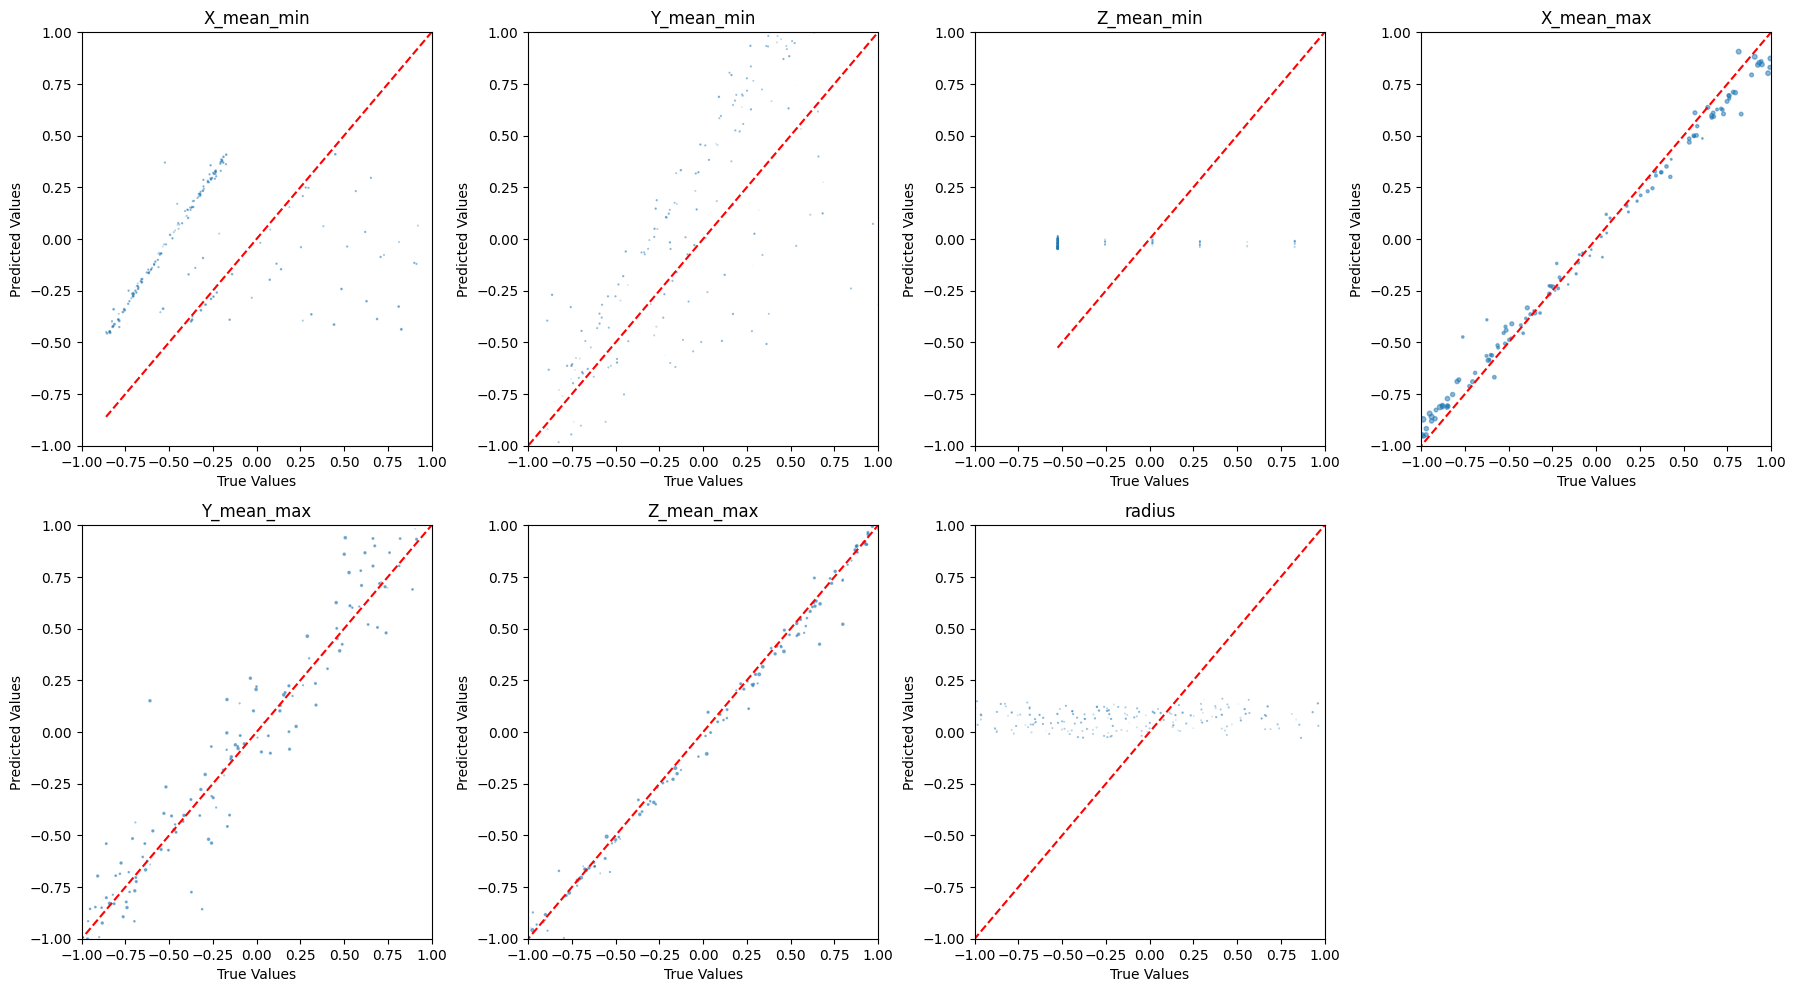

: 

In [ ]:
# plot targets vs predictions for validation set
y_mean, y_std = all_outputs.mean(0).detach(), all_outputs.std(0).detach()
true_output = all_targets.detach()

plt.figure(figsize=(18, 10))
# use 3 columns per row
for i, col in enumerate(output_columns):
    plt.subplot(len(output_columns)//4+1, 4, i+1)
    plt.scatter(true_output[:, i], y_mean[:, i], alpha=0.5)#, s=20*y_std[:, i]/y_std.max())
    plt.plot([true_output[:, i].min(), true_output[:, i].max()],
             [true_output[:, i].min(), true_output[:, i].max()], 'r--')
    
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(col)
plt.tight_layout(pad=1.0)
